# Advanced Analyzer Configuration

We [have seen](.Doclaynet_with_YOLO.ipynb) how to write a YOLO wrapper trained on the Doclaynet dataset on how to seamlessly integrate and use this model in the **deep**doctection Analyzer. 

This model allows to determine a fine graded layout structure on documents and having these layout segments detected we can configure the Analyzer to return an even more complex structure of a page. We are going through additional configuration options.

Once again, this notebook is released with an **AGPL-3.0** license because we make use of the ultralytics library.

In [1]:
import os

# Let's get some more verbose logs
os.environ["STD_OUT_VERBOSE"]="True"

import deepdoctection as dd

/home/janis/Documents/Repos/deepdoctection_pt/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[1123 17:37.37 @file_utils.py:36]  INF  PyTorch version 2.1.2+cu121 available.
[1123 17:37.37 @file_utils.py:74]  INF  Disabling Tensorflow because USE_TORCH is set


In [ ]:
!pip install ultralytics

## Adding the model wrapper for YOLO 

This following cell is copied and pasted from [here](.Doclaynet_with_YOLO.ipynb).

In [3]:
from __future__ import annotations 

from typing import Mapping
from deepdoctection.utils.types import PixelValues, PathLikeOrStr
from deepdoctection.utils.settings import TypeOrStr
from deepdoctection.utils.file_utils import Requirement

from ultralytics import YOLO

def _yolo_to_detectresult(results, categories) -> list[dd.DetectionResult]:
    """
    Converts YOLO detection results into DetectionResult objects using inference speed as confidence.

    :param results: YOLO detection results
    :param categories: List of category names or LayoutType enums for YOLO classes.
    :return: A list of DetectionResult objects
    """

    all_results: list[dd.DetectionResult] = []

    categories_name = categories.get_categories(as_dict=True)

            
    # Use inference speed as the confidence score (e.g., using 'inference' time as a proxy)
    confidence = results.speed.get('inference', 0) / 100  # Normalize by 100 if you want a scale between 0-1
    
    # Loop through each detected box
    for i, box in enumerate(results.boxes):
        # Extract and normalize bounding box coordinates
        x1, y1, x2, y2 = box.xyxy.tolist()[0]
        
        # Assign class_id based on detection order or results.boxes.cls if available
        class_id = int(box.cls)+1  # Get class ID based on available keys
        class_name = categories_name.get(class_id, "Unknown") # Directly retrieve the class name from categories
        
        # Create a DetectionResult object with inferred confidence
        detection = dd.DetectionResult(
            box=[x1, y1, x2, y2],
            score=confidence,  # Set the normalized speed as confidence
            class_id=class_id,
            class_name=class_name
        )
        
        # Append the DetectionResult to the list
        all_results.append(detection)

    return all_results

def predict_yolo(np_img: PixelValues, 
                 model, 
                 conf_threshold: float, 
                 iou_threshold: float, 
                 categories: dd.ModelCategories) -> list[dd.DetectionResult]:
    """
    Run inference using the YOLO model.
    
    :param np_img: Input image as numpy array (BGR format)
    :param model: YOLO model instance
    :param conf_threshold: Confidence threshold for detections
    :param iou_threshold: Intersection-over-Union threshold for non-max suppression
    :param categories: List of category names or LayoutType enums for YOLO classes.
    :return: A list of detection results
    """
    # Run the model
    results = model(source=np_img, conf=conf_threshold, iou=iou_threshold)[0]
    
    # Convert results to DetectionResult format
    all_results = _yolo_to_detectresult(results, categories)
    
    return all_results
    
class YoloDetector(dd.ObjectDetector):
    """
    Document detector using YOLO engine for layout analysis.
    
    Model weights must be placed at `.cache/deepdoctection/weights/yolo/`.
    
    The detector predicts different categories of document elements such as text, tables, figures, headers, etc.
    """
    def __init__(self, 
                 conf_threshold: float, 
                 iou_threshold: float, 
                 model_weights: PathLikeOrStr, 
                 categories: Mapping[int, TypeOrStr]) -> None:
        """
        :param conf_threshold: Confidence threshold for YOLO detections.
        :param iou_threshold: IoU threshold for YOLO detections.
        :param model_weights: Path to the YOLO model weights file.
        :param categories: List of category names or LayoutType enums for YOLO classes.
        """
        self.name = "yolo_detector"
        self.model_id = self.get_model_id()
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold

        # Load YOLO model with specified weights
        self.model = YOLO(model_weights)

        if categories is None:
            raise ValueError("A dictionary of category mappings must be provided.")
        self.categories =dd.ModelCategories(init_categories=categories)
        
    def predict(self, np_img: PixelValues) -> list[dd.DetectionResult]:
        """
        Perform inference on a document image using YOLOv10 and return detection results.
        
        :param np_img: Input image as numpy array (BGR format)
        :return: A list of DetectionResult objects.
        """
        return predict_yolo(np_img, self.model, self.conf_threshold, self.iou_threshold, self.categories)

    @classmethod
    def get_requirements(cls) -> list[Requirement]:
        # You could write a function get_ultralytics_requirement() that reminds you to install ultralytics which is necessary to run this
        # predictor. 
        return []

    def clone(self) -> YoloDetector:
        """
        Clone the current detector instance.
        """
        return self.__class__(conf_threshold=self.conf_threshold, 
                              iou_threshold=self.iou_threshold, 
                              model_weights=self.model.model_path,
                              categories = self.categories)

    def get_category_names(self) -> tuple[ObjectTypes, ...]:
        """
        Get the category names used by YOLO for document detection.
        """
        return self.categories.get_categories(as_dict=False)

dd.ModelCatalog.register("yolo/yolov10x_best.pt", dd.ModelProfile(
    name="yolo/yolov10x_best.pt",
    description="YOLOv10 model for layout analysis",
    tp_model=False,
    size=[],
    categories={
        1: dd.LayoutType.CAPTION,
        2: dd.LayoutType.FOOTNOTE,
        3: dd.LayoutType.FORMULA,
        4: dd.LayoutType.LIST_ITEM,
        5: dd.LayoutType.PAGE_FOOTER,
        6: dd.LayoutType.PAGE_HEADER,
        7: dd.LayoutType.FIGURE,
        8: dd.LayoutType.SECTION_HEADER,
        9: dd.LayoutType.TABLE,
        10: dd.LayoutType.TEXT,
        11: dd.LayoutType.TITLE,
    },
    model_wrapper="YoloDetector"
))

def build_layout_detector(config: AttrDict, mode: str = ""):
    weights = getattr(config.PT, mode).WEIGHTS
    profile = dd.ModelCatalog.get_profile(weights)
    if profile.model_wrapper == "YoloDetector":
        model_weights = dd.ModelCatalog.get_full_path_weights(config.PT.LAYOUT.WEIGHTS)
        return YoloDetector(conf_threshold=0.2,
                            iou_threshold=0.8,
                            model_weights=model_weights,
                            categories=profile.categories)

    else:
        # the code for building the many other layout/table/table segmentation predictors is hidden behind _build_layout_detector.
        return dd.ServiceFactory._build_layout_detector(config, mode)
    
dd.ServiceFactory.build_layout_detector=build_layout_detector

## Configuration to parse the page with respect to granular layout segments.

### Word matching

First we need to determine what layout segments should be tied to OCR results. We want to get text from:

`'caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title'`. 

Therefore, we set `WORD_MATCHING.PARENTAL_CATEGORIES` to be equal this list.

`WORD_MATCHING.CHILD_CATEGORIES` is equal to `word`, we don't need to change the default value.

### Ordering

`TEXT_ORDERING.TEXT_BLOCK_CATEGORIES` defines what layout segments must be taken into account for ordering words. In general, this must be equal to `WORD_MATCHING.PARENTAL_CATEGORIES`. 
`TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES` defines what layout segments must be taken into account for generating narative text. We do not want to have `table` or `caption`s to be part of the narrative text and these layout sections are therefore omitted.



In [ ]:
analyzer = dd.get_dd_analyzer(config_overwrite=["PT.LAYOUT.WEIGHTS=yolo/yolov10x_best.pt",
                                                "USE_TABLE_SEGMENTATION=True",
                                                "USE_OCR=True",
                                                "WORD_MATCHING.PARENTAL_CATEGORIES=['caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title']",
                                                "TEXT_ORDERING.TEXT_BLOCK_CATEGORIES=['caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title']",
                                                "TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES=['section_header', 'text','title','list_item','formula']"])

In [5]:
path="/path/to/some/document.pdf"

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

In [ ]:
dp = next(df_iter)

In [7]:
print(dp.text)

KNN-CTC: ENHANCING ASR VIA RETRIEVAL OF CTC PSEUDO LABELS
Jiaming Zhou', Shiwan Zhao*, Yagi Liu?, Wenjia Zeng’, Yong Chen’, Yong Qin'*

' China > Beijing University of Technology, Beijing, China 3 Lingxi (Beijing) Technology Co., Ltd.
Nankai University, Tianjin,


ABSTRACT
The success of retrieval-augmented language models in var- ious natural language processing (NLP) tasks has been con- strained in automatic speech recognition (ASR) applications due to challenges in constructing fine-grained audio-text datastores. This paper presents KNN-CTC, a novel approach that overcomes these challenges by leveraging Connection- ist Temporal Classification (CTC) pseudo labels to establish frame-level audio-text key-value pairs, circumventing the need for precise ground truth alignments. We further in- troduce a “skip-blank” strategy, which strategically ignores CTC blank frames, to reduce datastore size. By incorpo- rating a k-nearest neighbors retrieval mechanism into pre- trained CTC ASR system

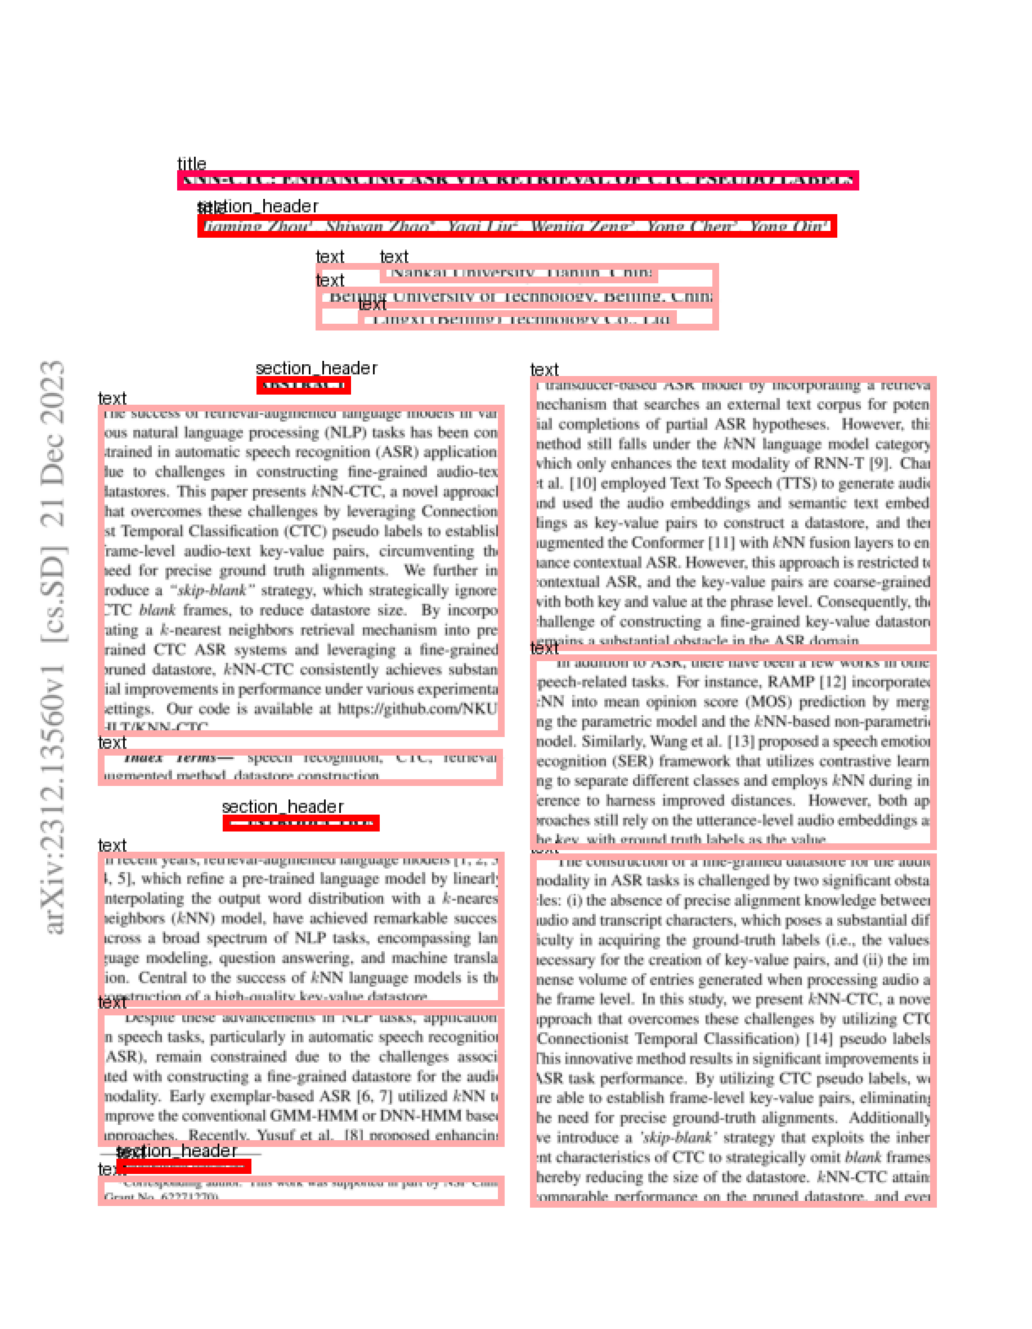

In [8]:
img = dp.viz(interactive=False)

from matplotlib import pyplot as plt

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(img)

## Extracting figures

Extracting layout sections is easy, because once they have been detected, they can be cut off from the image.

In [ ]:
dp = next(df_iter)

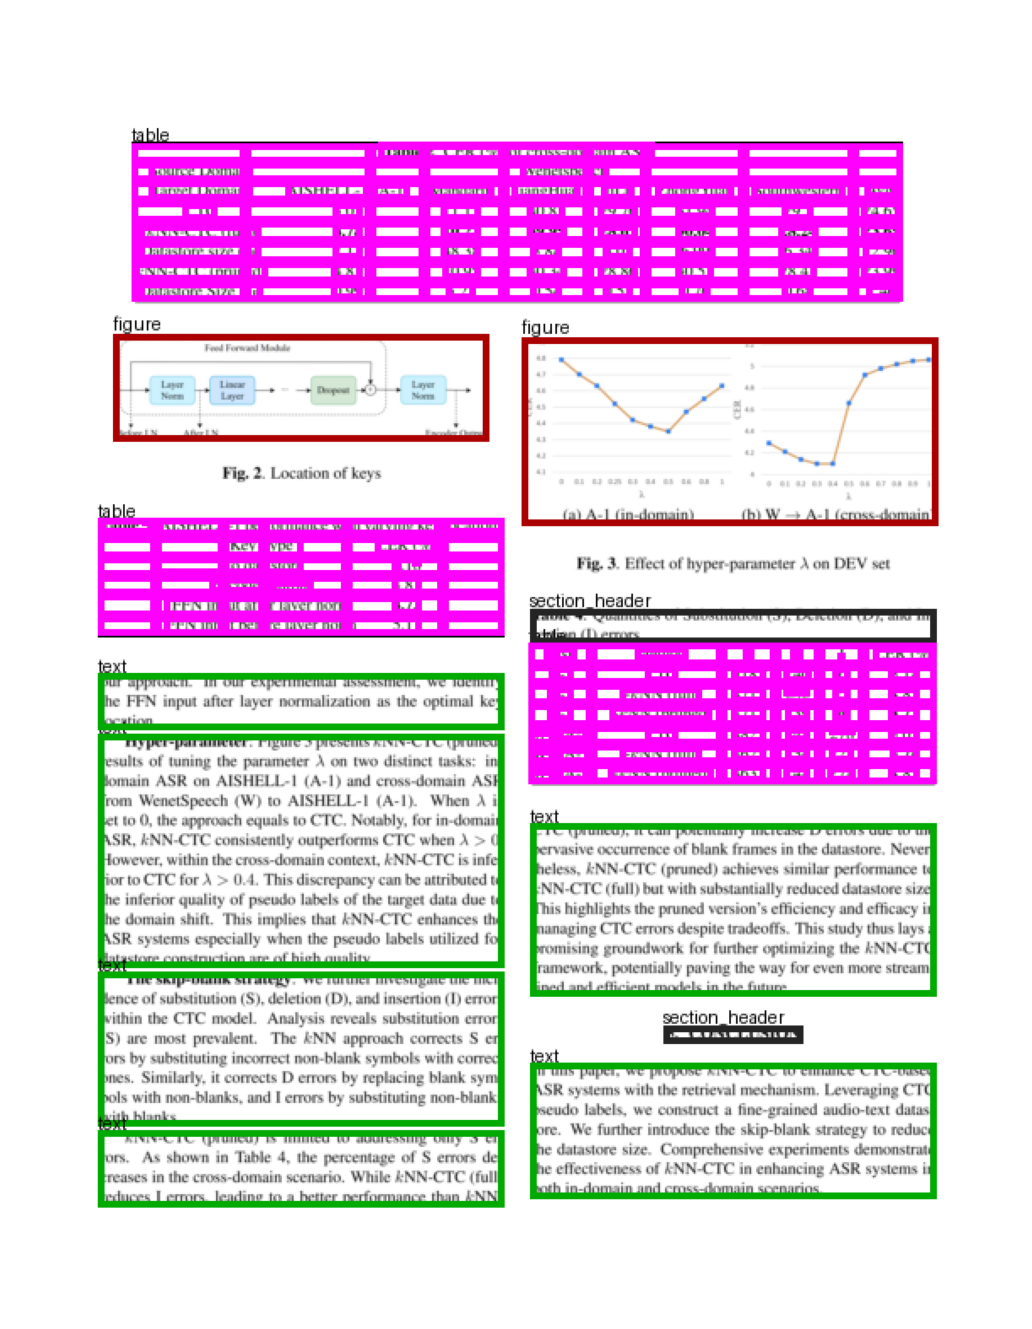

In [10]:
img = dp.viz(interactive=False, show_tables=True, show_figures=True)

from matplotlib import pyplot as plt

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(img)

In [11]:
# dp.figures returns a list of figures.

figure = dp.figures[0]

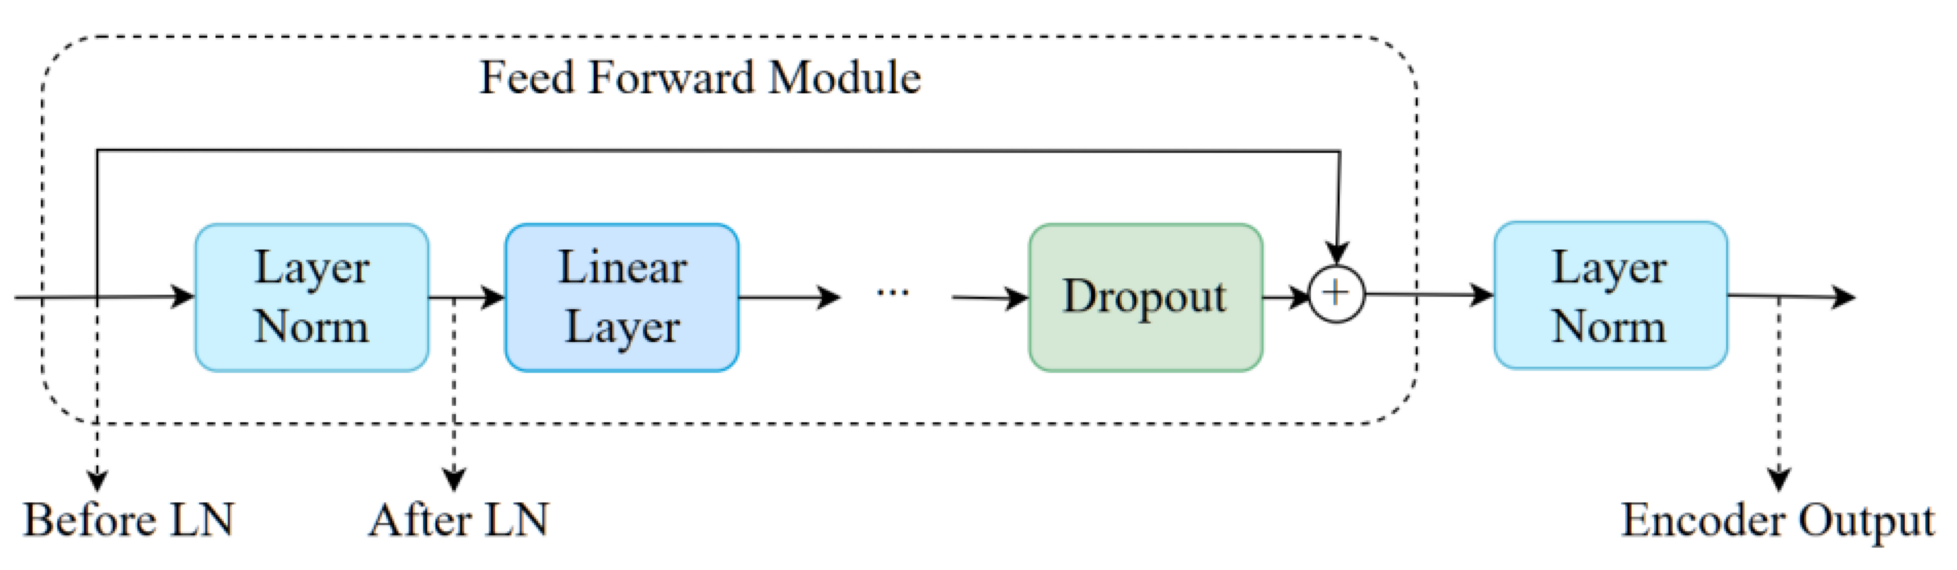

In [12]:
img = figure.viz(interactive=False)

plt.figure(figsize=(25, 17))
plt.axis('off')
plt.imshow(img)

It is very easy to save this figure in a separate file.

In [17]:
dd.viz_handler.write_image(f"/path/to/dir/{figure.annotation_id}.png", img)

'Fig. 2. Location of keys'

## Relating captions to figures and tables

Layout sections that are not tables, figures and that do not belong to narrative text will be routed to `residual_layouts`. 

But we can configure the Analyzer, such that `captions` are related to the neirest figure or table. 

In [14]:
dp.residual_layouts

[Layout(active=True, _annotation_id='c0fe285a-8e46-35cf-a5b5-a6b51fb2ac17', service_id='6e35cb1f', model_id='65303e0c', session_id=None, category_name=<LayoutType.CAPTION>, _category_name=<LayoutType.CAPTION>, category_id=1, score=0.12882709503173828, sub_categories={}, relationships={<Relationships.CHILD>: ['5096abf5-8b24-36d2-b9c6-b4cb9715dac7', '3dd5d4bd-278a-3691-8266-3fae4fd3a5b1', 'd01a487f-aa78-3016-91a9-afdace963038', 'e6821035-85cd-3d21-b7b2-5efc1597363d', '737347a5-a320-3d3d-a1f0-95fd205e94fa']}, bounding_box=BoundingBox(absolute_coords=True, ulx=534.1064453125, uly=1151.096923828125, lrx=935.619873046875, lry=1190.8302001953125, height=39.7332763671875, width=401.513427734375))]

In [ ]:
analyzer = dd.get_dd_analyzer(config_overwrite=["PT.LAYOUT.WEIGHTS=yolo/yolov10x_best.pt",
                                                "USE_TABLE_SEGMENTATION=True",
                                                "USE_OCR=True",
                                                "WORD_MATCHING.PARENTAL_CATEGORIES=['caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title']",
                                                "TEXT_ORDERING.TEXT_BLOCK_CATEGORIES=['caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title']",
                                                "TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES=['section_header','table','text','title','list_item','formula']",
                                                "USE_LAYOUT_LINK=True",   # Activating a distance matcher, that look to closest CHILD_CATEGORES and PARENTAL_CATEGORIES
                                                "LAYOUT_LINK.CHILD_CATEGORIES=['caption']", # Configuring the distance matcher: The layout section that should be tied to a parental layout section
                                                "LAYOUT_LINK.PARENTAL_CATEGORIES=['figure']"]) # and the declaration of the parental category. It can be a figure or ['figure','table']


Let's process the document again and use the distance matcher as well.

In [ ]:
df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

dp = next(df_iter)
dp = next(df_iter)

In [17]:
dp.figures

[Layout(active=True, _annotation_id='2b3d378c-dcf7-3350-9e79-1498f3222b5e', service_id='6e35cb1f', model_id='65303e0c', session_id=None, category_name=<LayoutType.FIGURE>, _category_name=<LayoutType.FIGURE>, category_id=7, score=0.13877630233764648, sub_categories={}, relationships={<Relationships.CHILD>: ['99be14e2-034e-3488-83fd-f97d6c124b12', '8ffb3c64-22e3-31dc-bea9-6431c6b22580', '123f0eee-40f9-3864-a610-4b0d9b1a3d89', 'f9f91c91-f6c6-37fe-96e8-60404b95aa5a', '0ef1a117-8f58-36d8-857c-07f8be6e8f01', '6f63cb26-1f81-3d40-80e1-53c87ca19618', '7806122a-aa1e-35ab-ac3c-b5d138e7b437', '49d6f835-fd4b-3124-b751-651bdaa5e5a8', 'd0754e54-a9a9-310d-84fd-c13722145eb7', 'df90f7b8-ec2a-3c7c-8354-7e035753170b', 'd92ee80f-a9f3-3d46-91f8-af4ea1d41039', '75d7dbf6-8cf5-3763-b394-1ffd97b2cdc1', '4891b598-d89c-3c52-a45a-5a3f040543f8', 'e7f3b7b9-475e-3d39-91ba-690c315410b5', '77cc0c81-0fbc-3e0a-91b3-a32aa258b119', 'c077831d-ddac-3e3b-a286-5b9b8fcbd9b2', '6a48492d-521e-3983-a2dd-55a9dd116d6a'], <Relationsh

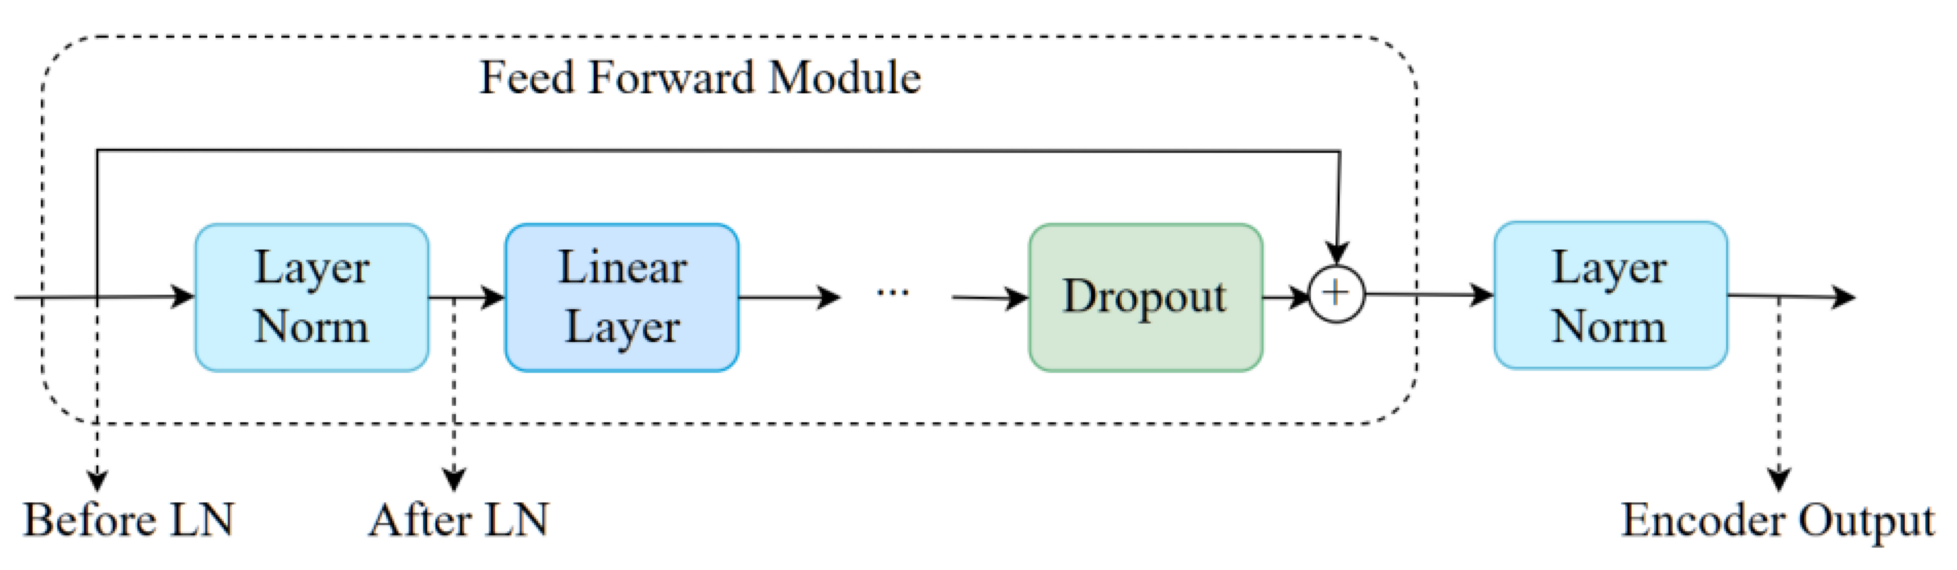

In [23]:
figure = dp.figures[0]

img = figure.viz(interactive=False)

plt.figure(figsize=(25, 17))
plt.axis('off')
plt.imshow(img)

The link of the parental category to its child can be retrieved from the `layout_link` attribute.

In [24]:
figure.layout_link[0].category_name
figure.layout_link[0].text

'Fig. 2. Location of keys'

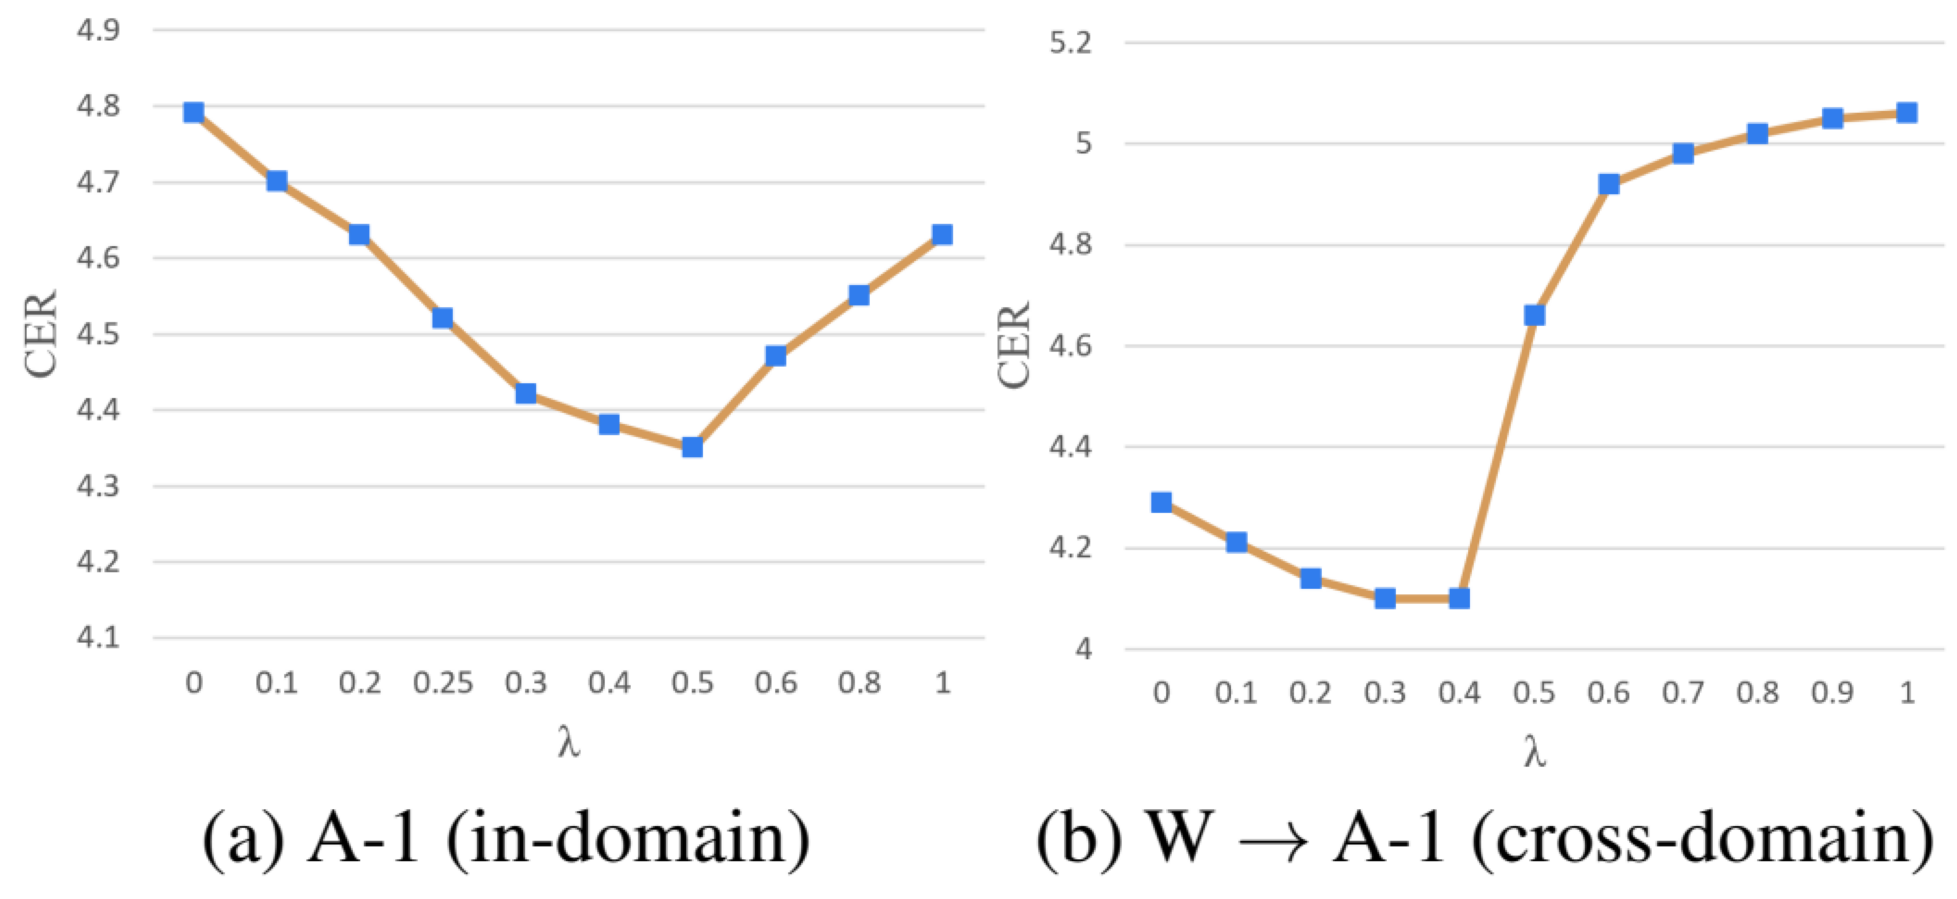

In [25]:
figure = dp.figures[1]

img = figure.viz(interactive=False)

plt.figure(figsize=(25, 17))
plt.axis('off')
plt.imshow(img)